### 1. Introduction

# Dataset
### Diabetes : https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download
## Penjelasan Atribut Dataset
- Pregnancies               : Untuk menyatakan Jumlah kehamilan
- Glucose                   : Tingkat Glukosa dalam darah 2 jam dalam tes toleransi glukosa oral
- BMI                       : Indeks massa tubuh (berat badan dalam kg/(tinggi dalam m)^2)
- Age                       : Umur (tahun)
- DiabetesPedigreeFunction  : Presentase keturunan diabetes
- BloodPressure             : Tekanan darah diastolik (mm Hg)
- SkinThickness             : Ketebalan lipatan kulit pada triceps (mm)
- insulin                   : Tingkat insulin dalam darah 

- Outcome                   : Menyatakan hasil akhir 1 adalah Ya (terkena diabetes) dan 0 adalah Tidak (tidak terkena diabetes)


### 2. Data Undestanding

2.1 Import Library

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pymongo import MongoClient
from imblearn.over_sampling import SMOTE
import joblib

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

2.2 Read Dataset

In [114]:
diabetes_dataset = pd.read_csv('diabetes.csv')
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


2.3 Insert Dataset ke MongoDB

In [115]:
client = MongoClient("mongodb://localhost:27017/")
db = client["diabetes_fix"]             
collection = db["data_diabetes"]

2.4 convert t dictionary and insert to mongodb

In [116]:
data_dict = diabetes_dataset.to_dict("records")
collection.insert_many(data_dict)
print(f"Inserted {len(data_dict)} records into MongoDB.")

Inserted 768 records into MongoDB.


2.5 Load Dataset dari MongoDB

In [117]:
# Ambil kembali data dari MongoDB
data = pd.DataFrame(list(collection.find()))

# Drop kolom _id jika ada
if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 3. Data Understanding

In [118]:
# Ukuran dataset
print("\n=== Ukuran Dataset ===")
print("Jumlah baris dan kolom:", diabetes_dataset.shape)

# Info tipe data
print("\n=== Info Dataset ===")
print(diabetes_dataset.info())

# Tipe data per kolom
print("\n=== Tipe Data per Kolom ===")
print(diabetes_dataset.dtypes)

# Cek missing values
print("\n=== Missing Values ===")
print(diabetes_dataset.isnull().sum())

# Cek duplikasi
print("\n=== Cek Duplikasi ===")
print("Jumlah duplikat:", diabetes_dataset.duplicated().sum())


=== Ukuran Dataset ===
Jumlah baris dan kolom: (768, 9)

=== Info Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== Tipe Data per Kolom ===
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness      

In [119]:
# Statistik deskriptif
print("\n=== Statistik Deskriptif ===")
print(diabetes_dataset.describe(include='all').to_string()) 


=== Statistik Deskriptif ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin         BMI  DiabetesPedigreeFunction         Age     Outcome
count   768.000000  768.000000     768.000000     768.000000  768.000000  768.000000                768.000000  768.000000  768.000000
mean      3.845052  120.894531      69.105469      20.536458   79.799479   31.992578                  0.471876   33.240885    0.348958
std       3.369578   31.972618      19.355807      15.952218  115.244002    7.884160                  0.331329   11.760232    0.476951
min       0.000000    0.000000       0.000000       0.000000    0.000000    0.000000                  0.078000   21.000000    0.000000
25%       1.000000   99.000000      62.000000       0.000000    0.000000   27.300000                  0.243750   24.000000    0.000000
50%       3.000000  117.000000      72.000000      23.000000   30.500000   32.000000                  0.372500   29.000000    0.000000
75%       6.000000  140.2

In [120]:
# Cek missing values
print("\n=== Missing Values ===")
print(diabetes_dataset.isnull().sum())


=== Missing Values ===
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [121]:
diabetes_dataset['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

### 4. Data Cleaning

4.1 Tangani Missing Values

In [122]:
# Kolom yang tidak boleh punya nilai 0
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ganti nilai 0 menjadi NaN
data[invalid_zero_cols] = data[invalid_zero_cols].replace(0, np.nan)

# Cek jumlah missing values
print("Missing values setelah diganti:")
print(data.isnull().sum())

Missing values setelah diganti:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


4.2 Hapus Kolom dengan Banyak Missing dan Korelasi Rendah

In [123]:
# Drop kolom 'Insulin' dan 'SkinThickness'
data.drop(['Insulin', 'SkinThickness'], axis=1, inplace=True)

Kolom Insulin dan SkinThickness memiliki lebih dari 30-40% nilai kosong (0 sebelumnya), serta korelasi rendah dengan Outcome. Maka, kita hapus.

4.3 Imputasi Missing Values untuk Kolom Penting

In [124]:
# Imputasi menggunakan median (lebih tahan outlier)
data.fillna(data.median(numeric_only=True), inplace=True)

# Cek kembali
print("Cek missing setelah imputasi:")
print(data.isnull().sum())


Cek missing setelah imputasi:
Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


4.4 Tangani Duplikasi

In [125]:
data.drop_duplicates(inplace=True)

4.3 Tangani Outlier 

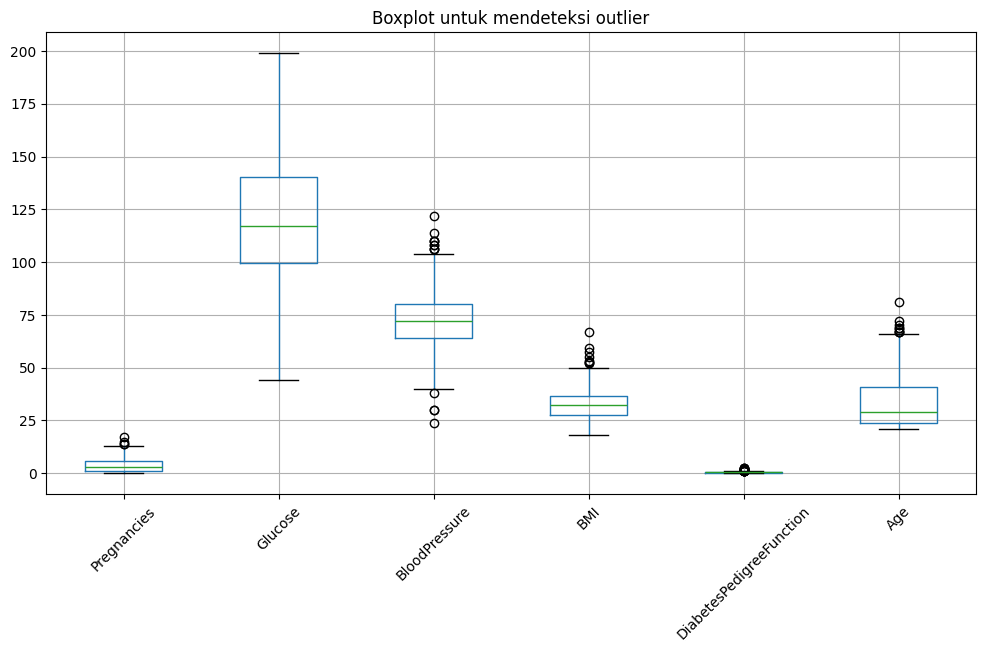

In [126]:
# Visualisasi boxplot semua fitur numerik
plt.figure(figsize=(12,6))
data.drop('Outcome', axis=1).boxplot()
plt.title("Boxplot untuk mendeteksi outlier")
plt.xticks(rotation=45)
plt.show()

In [127]:
# Salin data ke variabel baru
df = data.copy()

# Fungsi untuk menghapus outlier menggunakan metode IQR
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after = df.shape[0]

        print(f"Kolom {col}: Dihapus {before - after} baris outlier")

    return df

# Kolom numerik yang akan dicek outlier-nya (tanpa kolom target)
numerical_cols = df.drop('Outcome', axis=1).columns

# Terapkan fungsi dan simpan ke variabel `data` lagi
data = remove_outliers_iqr(df, numerical_cols)

# Cek bentuk data setelah cleaning
print("Shape data setelah buang outlier:", data.shape)

Kolom Pregnancies: Dihapus 4 baris outlier
Kolom Glucose: Dihapus 0 baris outlier
Kolom BloodPressure: Dihapus 14 baris outlier
Kolom BMI: Dihapus 9 baris outlier
Kolom DiabetesPedigreeFunction: Dihapus 28 baris outlier
Kolom Age: Dihapus 15 baris outlier
Shape data setelah buang outlier: (698, 7)


### 5. Data Transformation

5.1 Korelasi dan Seleksi Fitur Penting

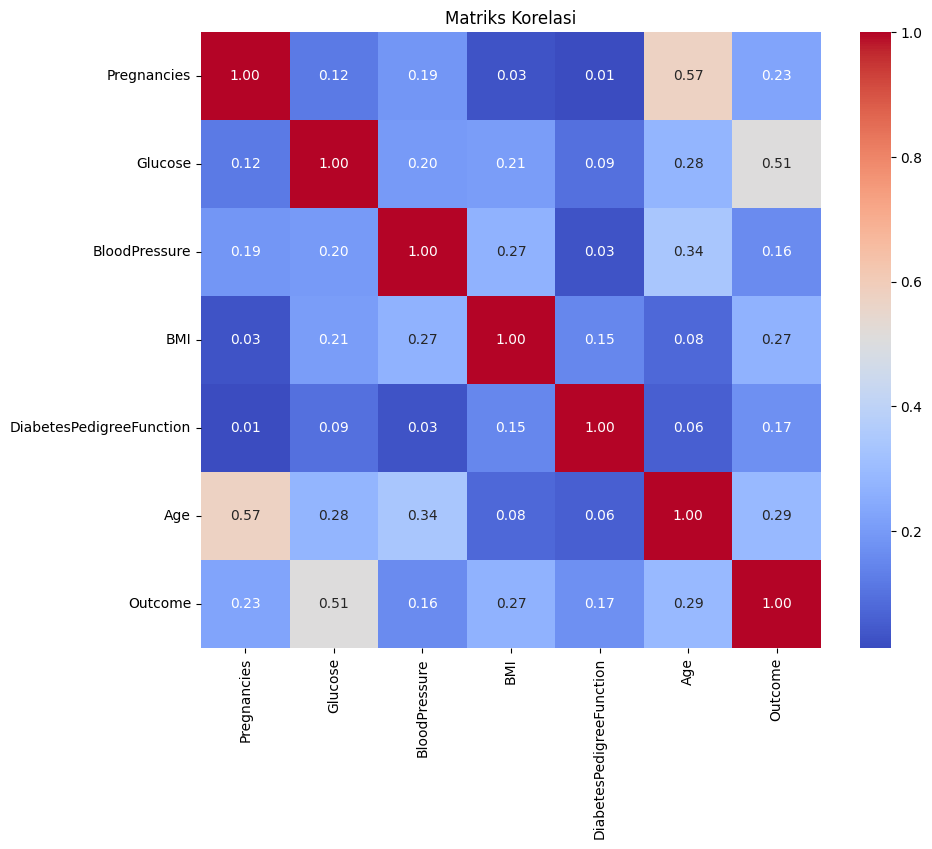

Korelasi fitur dengan Outcome:
 Glucose                     0.507943
Age                         0.292280
BMI                         0.270500
Pregnancies                 0.225776
DiabetesPedigreeFunction    0.173706
BloodPressure               0.162660
Name: Outcome, dtype: float64
Fitur terpilih: ['Glucose', 'Age', 'BMI', 'Pregnancies']


In [128]:
# Hitung korelasi antar fitur
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

# Tampilkan korelasi fitur terhadap target (Outcome)
cor_target = data.corr()['Outcome'].drop('Outcome').sort_values(ascending=False)
print("Korelasi fitur dengan Outcome:\n", cor_target)

# Seleksi fitur dengan korelasi di atas threshold (misal > 0.2)
selected_features = cor_target[abs(cor_target) > 0.2].index.tolist()
print("Fitur terpilih:", selected_features)

5.2 Normalisasi Data (Min-Max Scaling)

In [ ]:
# Inisialisasi scaler
scaler = MinMaxScaler()

# Scaling fitur terpilih saja
data_scaled = data.copy()
data_scaled[selected_features] = scaler.fit_transform(data_scaled[selected_features])

# Cek hasil normalisasi
data_scaled.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.461538,0.675325,72.0,0.495177,0.627,0.674419,1
1,0.076923,0.266234,66.0,0.270096,0.351,0.232558,0
2,0.615385,0.902597,64.0,0.163987,0.672,0.255814,1
3,0.076923,0.292208,66.0,0.318328,0.167,0.000000,0
5,0.384615,0.467532,74.0,0.237942,0.201,0.209302,0


In [ ]:
# memisahkan data dan label
X = diabetes_dataset.drop (columns='Outcome', axis=1)
Y = diabetes_dataset['Outcome']

In [131]:
print(X)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1                       0.351   31  


In [132]:
print(Y)

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64


standarisasi data

In [133]:
scaler = StandardScaler()

In [134]:
scaler.fit(X)

StandardScaler()

In [135]:
standarized_data = scaler.transform(X)

In [136]:
print(standarized_data)

[[ 0.63994726  0.84832379  0.14964075 ...  0.20401277  0.46849198
   1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575 ... -0.68442195 -0.36506078
  -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 ... -1.10325546  0.60439732
  -0.10558415]
 ...
 [ 0.3429808   0.00330087  0.14964075 ... -0.73518964 -0.68519336
  -0.27575966]
 [-0.84488505  0.1597866  -0.47073225 ... -0.24020459 -0.37110101
   1.17073215]
 [-0.84488505 -0.8730192   0.04624525 ... -0.20212881 -0.47378505
  -0.87137393]]


In [137]:
X = standarized_data
Y = diabetes_dataset['Outcome']

In [138]:
print(X)
print(Y)

[[ 0.63994726  0.84832379  0.14964075 ...  0.20401277  0.46849198
   1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575 ... -0.68442195 -0.36506078
  -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 ... -1.10325546  0.60439732
  -0.10558415]
 ...
 [ 0.3429808   0.00330087  0.14964075 ... -0.73518964 -0.68519336
  -0.27575966]
 [-0.84488505  0.1597866  -0.47073225 ... -0.24020459 -0.37110101
   1.17073215]
 [-0.84488505 -0.8730192   0.04624525 ... -0.20212881 -0.47378505
  -0.87137393]]
0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64


## 4. Exploratory Data Analysis (EDA)

# 1. Analisis Univariate

<Figure size 1200x800 with 0 Axes>

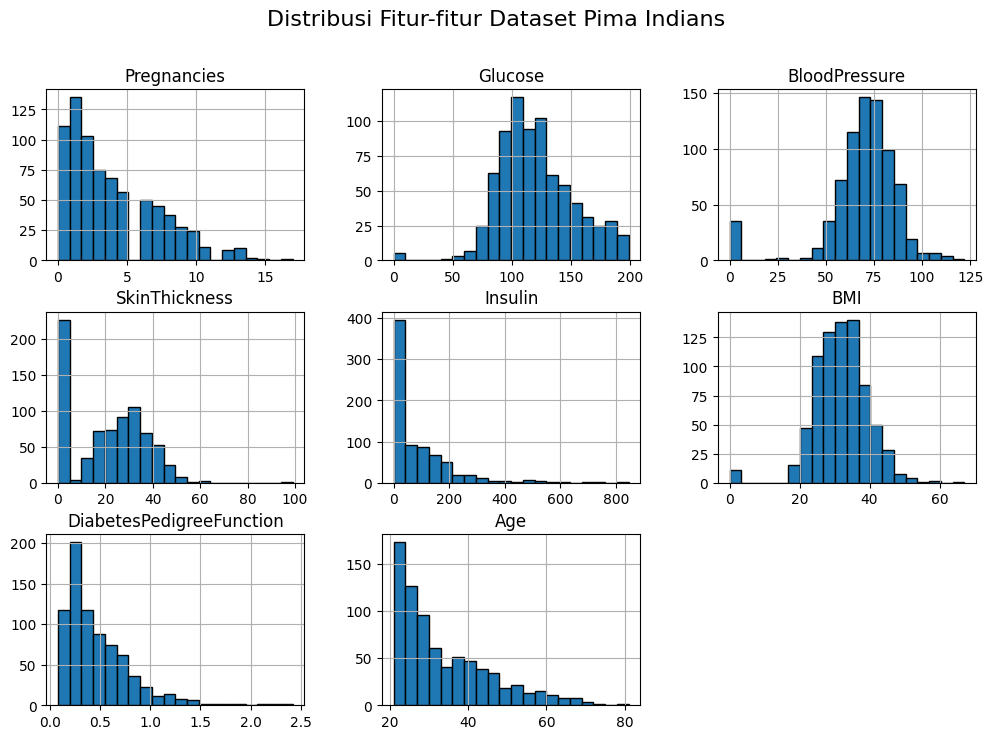

In [139]:
# 1. Visualisasi distribusi fitur numerik
plt.figure(figsize=(12, 8))
diabetes_dataset.drop('Outcome', axis=1).hist(bins=20, edgecolor='black', figsize=(12, 8))
plt.suptitle("Distribusi Fitur-fitur Dataset Pima Indians", fontsize=16)
plt.show()

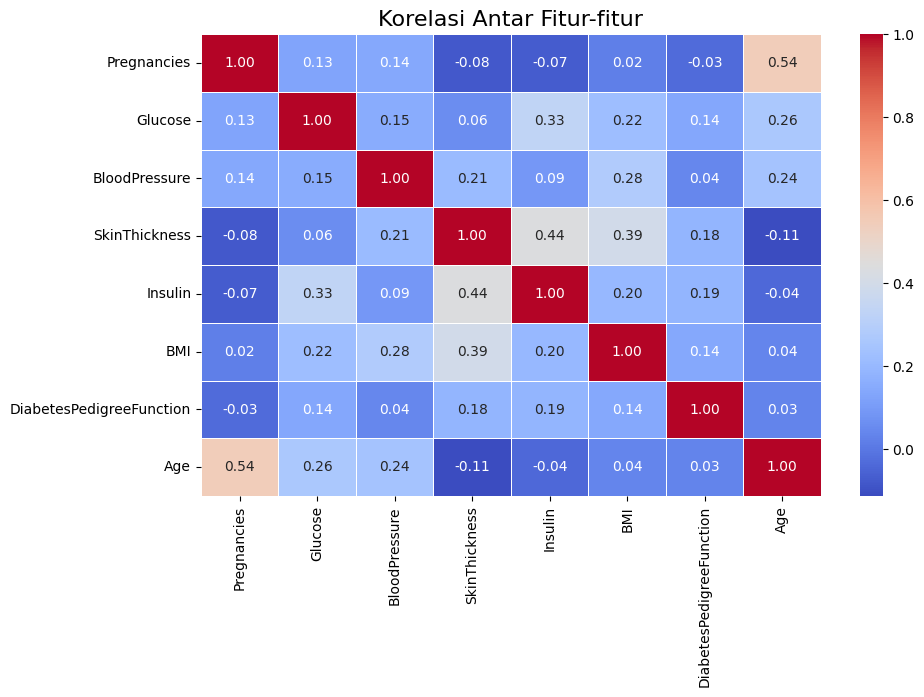

In [140]:
# 2. Visualisasi korelasi antar fitur menggunakan heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = diabetes_dataset.drop('Outcome', axis=1).corr()  # Mengabaikan 'Outcome' untuk korelasi fitur
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Korelasi Antar Fitur-fitur", fontsize=16)
plt.show()


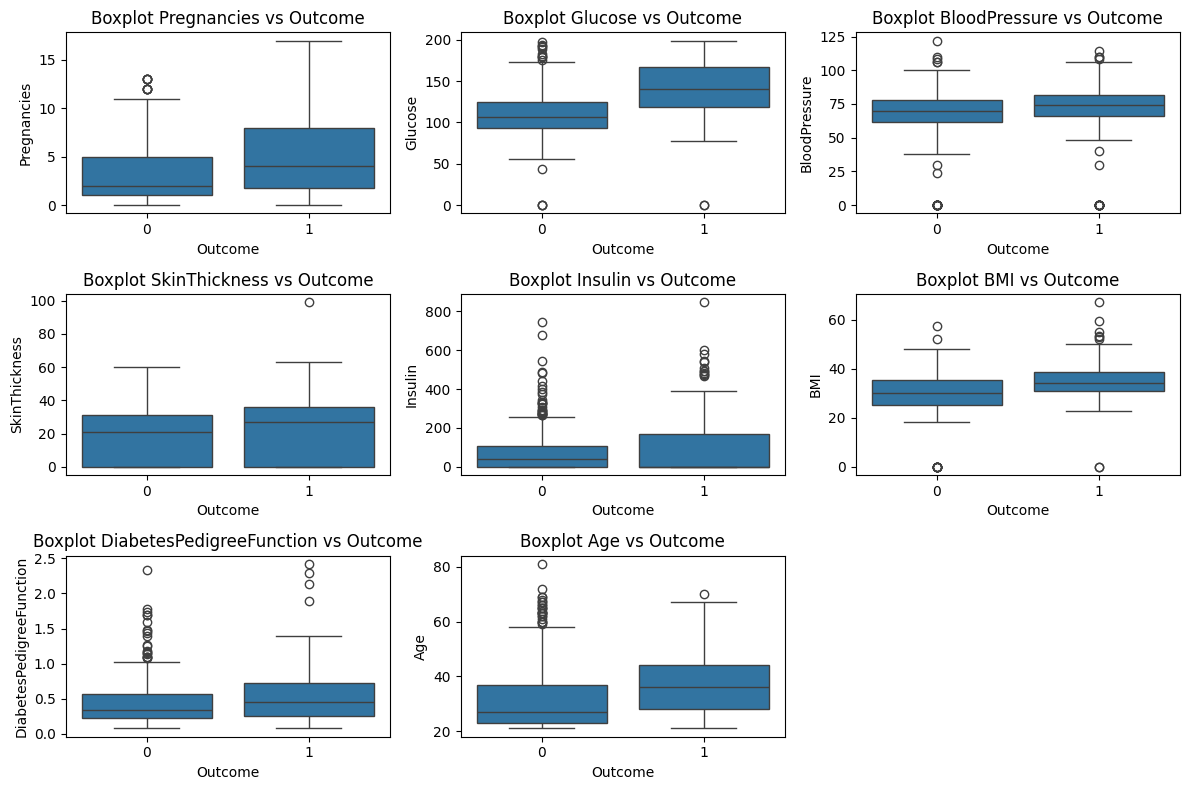

In [141]:
# 3. Boxplot untuk visualisasi pencilan
plt.figure(figsize=(12, 8))
for i, feature in enumerate(diabetes_dataset.drop('Outcome', axis=1).columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Outcome', y=feature, data=diabetes_dataset)
    plt.title(f'Boxplot {feature} vs Outcome')
plt.tight_layout()
plt.show()

Analisis univariat dilakukan untuk memahami distribusi masing-masing variabel secara individu.

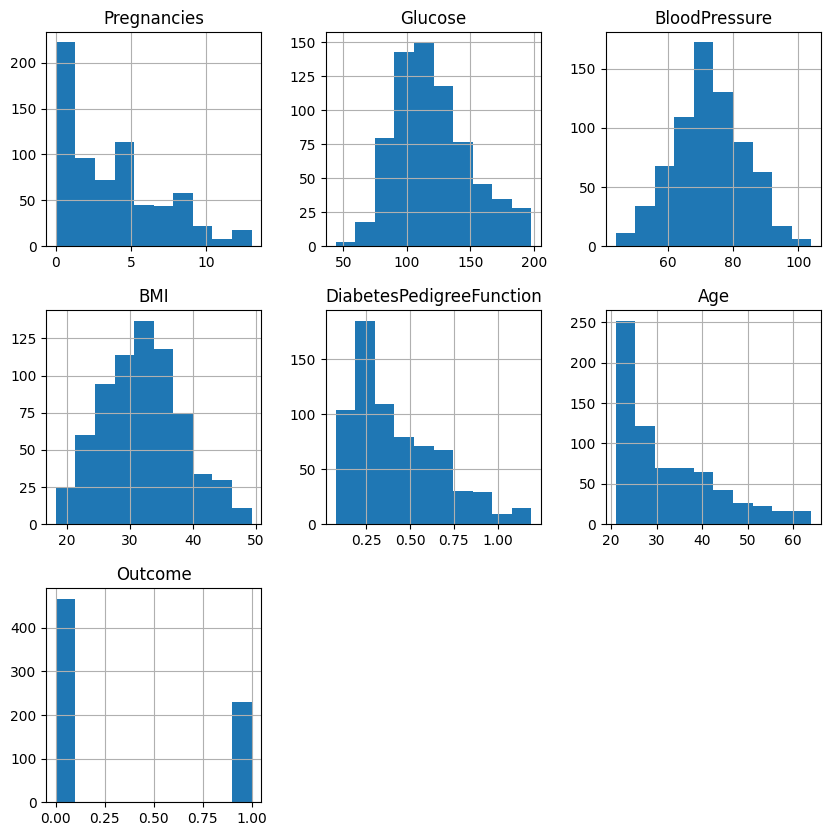

In [142]:
# histogram Distribusi Seluruh Variabel
data.hist(figsize=(10,10))
plt.show()

C:\Users\Mega Global\AppData\Local\Temp\ipykernel_12812\984233593.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x='Outcome', data=data, palette='Set2')


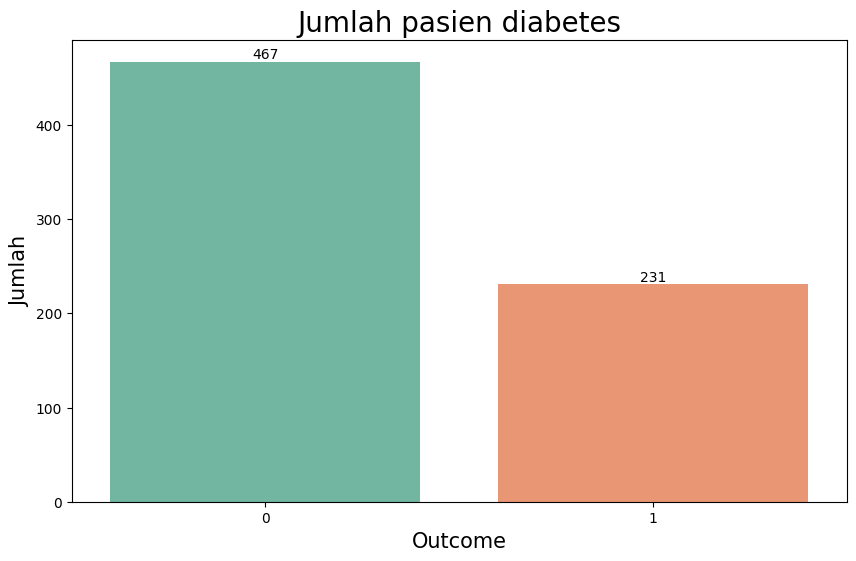

In [143]:
# Distribusi Variabel Target (Outcome)
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', data=data, palette='Set2')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien diabetes', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.show()

Data yang disajikan menggambarkan bahwa terdapat 268 orang yang mengalami diabetes, sedangkan sebanyak 500 orang tidak mengalami kondisi diabetes.

# 2. Analisis Bivariate

Analisis bivariat dilakukan untuk melihat hubungan dua variabel, misalnya antara Outcome dan variabel lain.

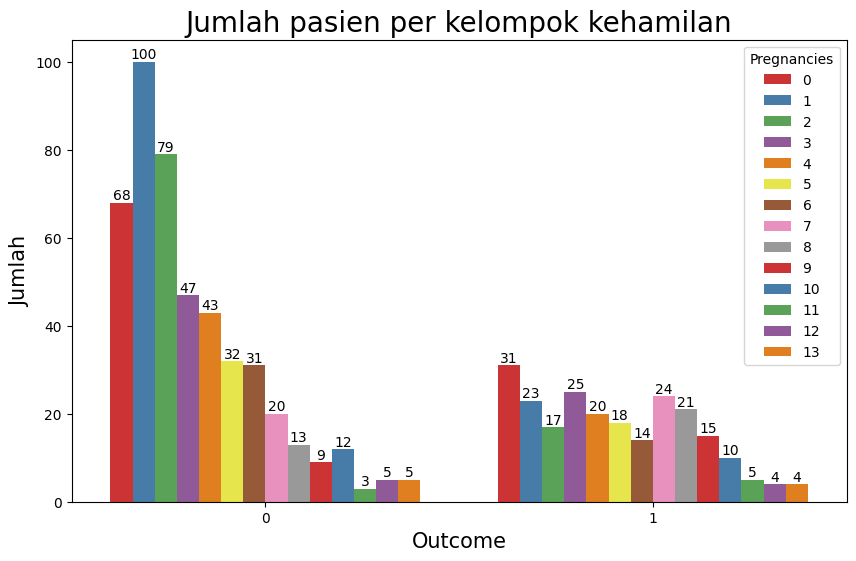

In [144]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='Pregnancies', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok kehamilan', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.show() 

Jumlah pasien perkelompok kehamilan yang paling banyak terkena diabets adalah 0 kehamilan dengan jumlah 38 orang lalu diikuti dengan 3 kehamilan dengan jumlah 27 orang dan yang paling sedikit adalah 17 kehamilan dengan jumlah 1 orang.

# 3. Analisis Multivariate

Analisis multivariat melihat hubungan lebih dari dua variabel.

In [145]:
# Menambahkan kolom kelompok umur
age_grup = []
for i in data['Age']:
    if i >= 17 and i <= 25:
        age_grup.append('Remaja Akhir')
    elif i >= 26 and i <= 35:
        age_grup.append('Dewasa Awal')
    elif i >= 36 and i <= 45:
        age_grup.append('Dewasa Akhir')
    elif i >= 46 and i <= 55:
        age_grup.append('Lansia Awal')
    elif i >= 56 and i <= 65:
        age_grup.append('Lansia Akhir')
    else:
        age_grup.append('Manula')
data['Age_grup'] = age_grup

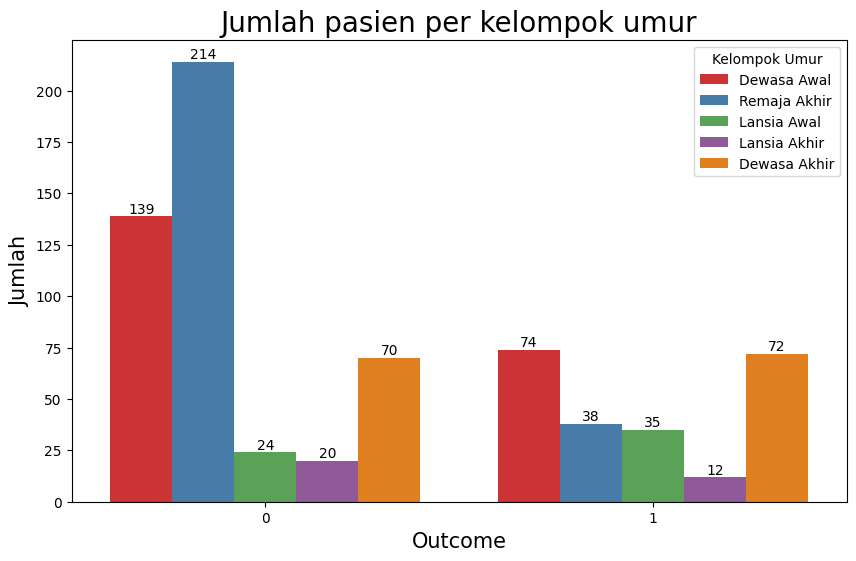

In [146]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='Age_grup', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok umur', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15) 
plt.legend(loc='upper right', title='Kelompok Umur')  
plt.show() 

In [147]:
data[['Outcome', 'Age_grup']].value_counts()

Outcome  Age_grup    
0        Remaja Akhir    214
         Dewasa Awal     139
1        Dewasa Awal      74
         Dewasa Akhir     72
0        Dewasa Akhir     70
1        Remaja Akhir     38
         Lansia Awal      35
0        Lansia Awal      24
         Lansia Akhir     20
1        Lansia Akhir     12
Name: count, dtype: int64

Banyak pasien yang terkena diabetes adalah yang berumur 26-35 tahun atau dewasa awal dengan jumlah 86 orang lalu diikutu dengan dewasa akhir yaitu 46-55 tahun dengan jumlah 79 orang dan yang paling sedikit adalah manula dengan jumlah 4 orang.

In [148]:
BMI_grup = []
for i in data['BMI']:
    if i >= 0 and i <= 18.5:
        BMI_grup.append('Kurus')
    elif i >= 18.6 and i <= 22.9:
        BMI_grup.append('Normal')
    elif i >= 23 and i <= 24.9:
        BMI_grup.append('Gemuk')
    elif i >= 25 and i <= 29.9:
        BMI_grup.append('Obesitas')
    else:
        BMI_grup.append('Obesitas II')            

In [149]:
data['BMI_grup'] = BMI_grup
data

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_grup,BMI_grup
0,6,148.0,72.0,33.6,0.627,50,1,Lansia Awal,Obesitas II
1,1,85.0,66.0,26.6,0.351,31,0,Dewasa Awal,Obesitas
2,8,183.0,64.0,23.3,0.672,32,1,Dewasa Awal,Gemuk
3,1,89.0,66.0,28.1,0.167,21,0,Remaja Akhir,Obesitas
5,5,116.0,74.0,25.6,0.201,30,0,Dewasa Awal,Obesitas
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,32.9,0.171,63,0,Lansia Akhir,Obesitas II
764,2,122.0,70.0,36.8,0.340,27,0,Dewasa Awal,Obesitas II
765,5,121.0,72.0,26.2,0.245,30,0,Dewasa Awal,Obesitas
766,1,126.0,60.0,30.1,0.349,47,1,Lansia Awal,Obesitas II


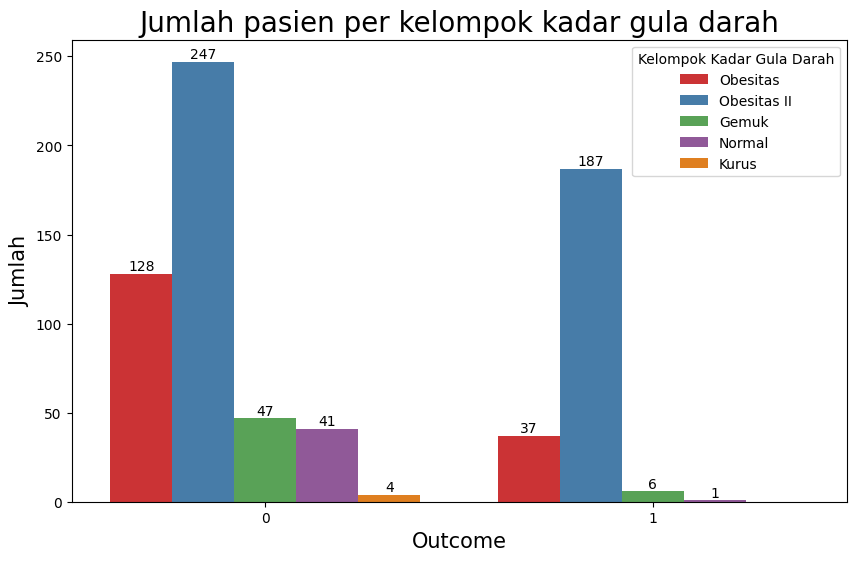

In [150]:
plt.figure(figsize=(10,6))
a = sns.countplot(x='Outcome', hue='BMI_grup', data=data, palette='Set1')
for j in a.containers:
    a.bar_label(j, label_type='edge')
plt.title('Jumlah pasien per kelompok kadar gula darah', fontsize=20)
plt.xlabel('Outcome', fontsize=15)
plt.ylabel('Jumlah', fontsize=15)
plt.legend(loc='upper right', title='Kelompok Kadar Gula Darah')
plt.show()    

In [151]:
data[['Outcome', 'BMI_grup']].value_counts()

Outcome  BMI_grup   
0        Obesitas II    247
1        Obesitas II    187
0        Obesitas       128
         Gemuk           47
         Normal          41
1        Obesitas        37
         Gemuk            6
0        Kurus            4
1        Normal           1
Name: count, dtype: int64

Berdasarkan kelompok BMI yang paling banyak terkena diabetes adalah yang memiliki BMI lebih dari 30 (Obesitasa II) dengan jumlah 219 orang lalu diikuti dengan BMI 25 - 29.9 (Obesitas) dengan jumlah 40 orang.

In [152]:
data = data.drop(columns=['Age_grup', 'BMI_grup'])
print(data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [153]:
print(data.columns)
print(data.isnull().sum())
data = data.drop_duplicates()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [154]:
#print(data.isnull().sum())
#data['Insulin'] = data['Insulin'].fillna(data['Insulin'].median())

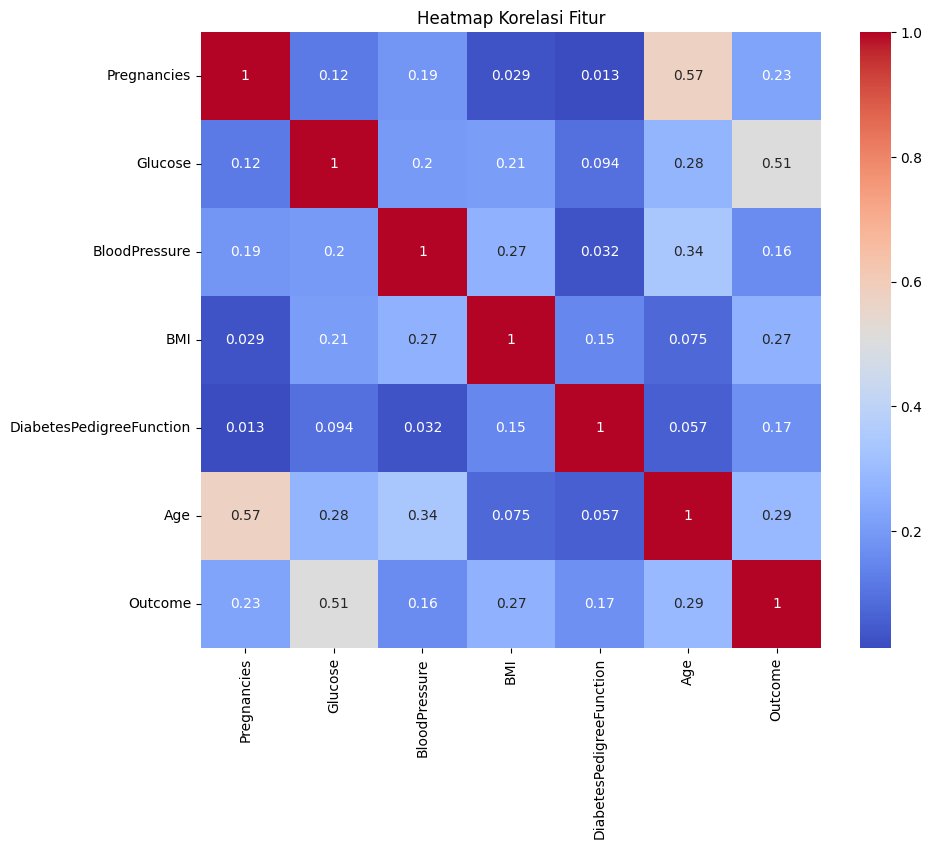

In [155]:
corr = data.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

In [156]:
print(data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


# 5. Data Transformation

In [173]:
#pesiapan data 
selected_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = data[selected_features]
y = data['Outcome']  # label target

In [ ]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# STANDARISASI FITUR (dengan StandardScaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # fit ke training, transform training
X_test = scaler.transform(X_test)        # hanya transform test

# 6. Modeling

Memisahkan Data Training dan Data Testing

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(768, 8) (614, 8) (154, 8)


In [171]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "SVM": SVC(kernel='linear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),  # Perbaikan: hanya satu random_state
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),  # Perbaikan: hanya satu random_state
    "AdaBoost": AdaBoostClassifier(random_state=42),  # Perbaikan: hanya satu random_state
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB()
}

results = {}

for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    results[name] = accuracy

print("Hasil Evaluasi Model:")
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy:.4f}")

best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]
print(f"\nModel Terbaik: {best_model_name} dengan Akurasi = {best_model_accuracy:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [558, 614]

Membuat data latih menggunakan algoritma SVM

In [160]:
classifier = SVC(kernel='linear')

In [161]:
classifier.fit(X_train, Y_train)

SVC(kernel='linear')

In [162]:
SVC(kernel='linear')

SVC(kernel='linear')

# 7. Evaluation

membuat model evaluasi untuk mengukur tingkat akurasi

In [163]:
X_train_prediction = classifier.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [164]:
print('Akurasi data training adalah = ', training_data_accuracy)

Akurasi data training adalah =  0.7866449511400652


In [165]:
X_test_prediction = classifier.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [166]:
print('Akurasi data testing adalah = ', test_data_accuracy)

Akurasi data testing adalah =  0.7727272727272727


Membuat Model Prediksi

In [169]:
# Input dengan 6 fitur saja
input_data = (6, 148, 72, 33.6, 0.627, 50)  # sudah sesuai urutan: Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction, Age

input_data_as_numpy_array = np.array(input_data)

input_data_reshape = input_data_as_numpy_array.reshape(1, -1)

std_data = scaler.transform(input_data_reshape)
print(std_data)

prediction = classifier.predict(std_data)
print(prediction)

if prediction[0] == 0:
    print('Pasien tidak terkena diabetes')
else:
    print('Pasien terkena diabetes')

c:\Users\Mega Global\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 6 features, but StandardScaler is expecting 8 features as input.

simpan model

In [168]:
import pickle

filename = 'diabetes_model.pkl' 
pickle.dump(classifier, open(filename, 'wb'))